
# **ECSE  415 Assignment 3**
#Melis Malki - 260775809
##November 23, 2020

##**Initialization**

In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Image Segmentation using K-means**

In [ ]:
# Read the images
home = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_4/home.jpg')
flower = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_4/flower.jpg')



Home Image
K=2


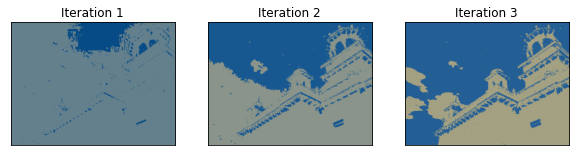

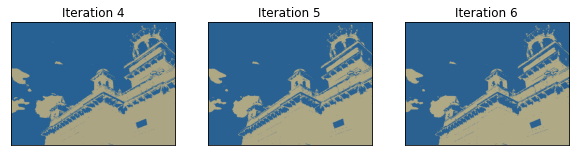

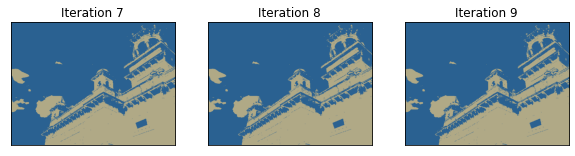

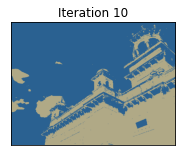

K=3


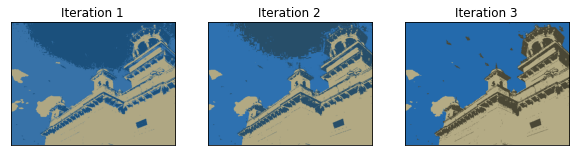

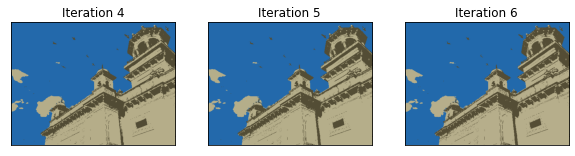

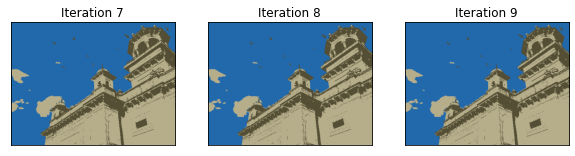

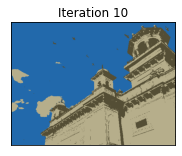

Flower Image
K=2


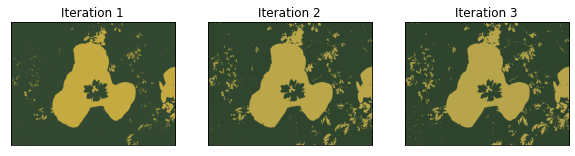

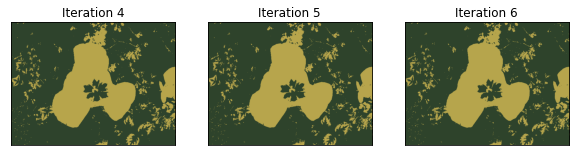

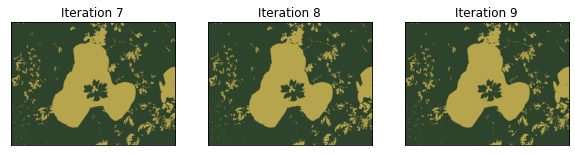

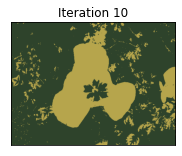

K=3


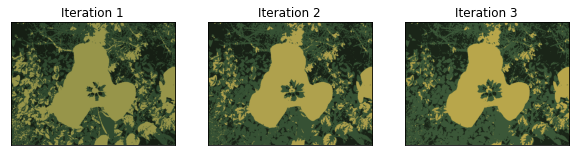

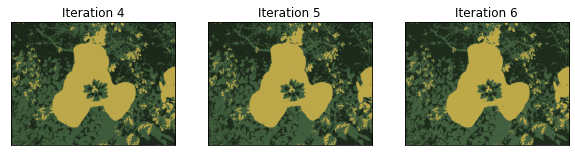

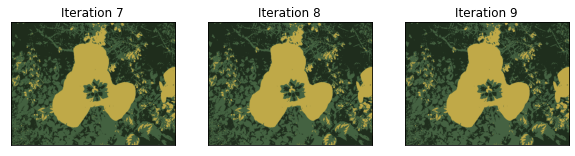

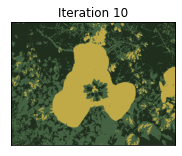

In [ ]:
def kmeans(image,K):
    iteration = 10
    width, height, ch = image.shape

    Z = np.float32(image.reshape(width*height,ch))
    
    # Random K center - We do this by create a random array for each K 
    center = Z[np.random.randint(Z.shape[0], size=K)]
    
    # Zero matrix for defining the distance  
    distance = np.zeros([Z.shape[0], K], dtype=np.float64)
   
    cluster_iteration = []
    for i in range(iteration):
        for i, j in enumerate(center):
          # Euclidian Distance
          distance[:, i] = np.linalg.norm(Z - j, axis=1)

        # Adjust clusters based on minimal distance
        min_distance = np.argmin(distance, axis=1)
        # Adjust center
        for k in range(K):
            center[k] = np.mean(Z[min_distance == k], 0)
        
        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        cluster = center[min_distance.flatten()]
        cluster = cluster.reshape(image.shape)
        cluster_iteration.append(cluster)
    print(f"K={K}")
    for i in range(len(cluster_iteration)):
      if(i%3==0):
          plt.figure(figsize=(10,10))
      plt.subplot(130+((i%3)+1)), plt.imshow(cluster_iteration[i])
      plt.title("Iteration "+str(i+1)), plt.xticks([]), plt.yticks([])
    plt.show()

#Apply K-mean segmentation to images
print("Home Image")
kmeans(home,2)
kmeans(home,3)
print("Flower Image")
kmeans(flower,2)
kmeans(flower,3)



##**Disparity**

Text(0.5, 1.0, 'Disparity Map')

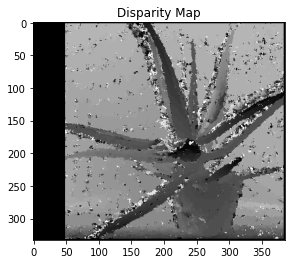

In [ ]:
# Preapare the images
left = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_4/aloeL.jpg')
right = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_4/aloeR.jpg')

left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

left = cv2.resize(left, None, fx=0.3, fy=0.3)
right = cv2.resize(right, None, fx=0.3, fy=0.3)

D = np.zeros([left.shape[0], left.shape[1]], dtype=np.float32)

for i_left in range(0, left.shape[0]): 
  for j_left in range(0, left.shape[1]): 
    # Extract 5X5 Reference window
    ref_window = left[(i_left - 2) : (i_left + 3), (j_left - 2) : (j_left + 3)]
    
    if ref_window.shape == (5,5):
      # Search Region
      min = float(300)
      for j_right  in range((j_left - 47) , (j_left + 1)):
        search_region = right[(i_left - 2) : (i_left + 3) , (j_right - 2) : (j_right + 3) ]
        
        if search_region.shape == (5,5):
          #Compute SSD
          SSD = np.sum( np.sqrt((ref_window - search_region)**2 ))
          if SSD < min:
            min = SSD
            D[i_left,j_left] = j_left - j_right
          
        #If search region lies outside the boundary of the image
        else : 
          D[i_left,j_left] = 48
          break

    #If reference window lies outside the boundary of the image
    else: 
      D[i_left,j_left] = 48
      

plt.imshow(D, cmap="gray_r")
plt.title("Disparity Map")

##**Optical Flow**

MSE values for different winsizes
Winsize: 5, MSE:1.1078871292407568
Winsize: 7, MSE:0.8553900806710658
Winsize: 9, MSE:0.7471773898916974
Winsize: 11, MSE:0.6804231877514776
Winsize: 13, MSE:0.6402810729175292
Winsize: 15, MSE:0.6137743711932968
Winsize: 17, MSE:0.5945856853354827
Winsize: 19, MSE:0.578629372262482
Winsize: 21, MSE:0.5646491703232063


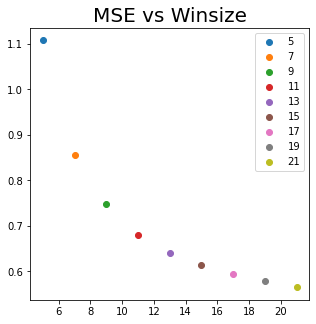

In [165]:
frame10 = cv2.imread('/content/drive/My Drive/ECSE 415/Assignment_4/frame10.png')
frame11 = cv2.imread('/content/drive/My Drive/ECSE 415/Assignment_4/frame11.png')
frame10 = cv2.cvtColor(frame10, cv2.COLOR_RGB2GRAY)
frame11  = cv2.cvtColor(frame11, cv2.COLOR_RGB2GRAY)

gt = np.load('/content/drive/My Drive/ECSE 415/Assignment_4/flow10.npz')['flow']

winsize = range(5,23,2)
MSE = dict()
print("MSE values for different winsizes")
for w in winsize:
  flow = cv2.calcOpticalFlowFarneback(frame10,frame11,winsize=w,flow=None,pyr_scale=0.5, levels=3,iterations=3, poly_n=5, poly_sigma=1.2,flags=0)
  MSE[w] = np.mean((gt - flow)**2)
  print(f"Winsize: {w}, MSE:{MSE[w]}")

plt.figure(figsize=(5,5))

plt.title("MSE vs Winsize", fontsize=20)
for w in winsize:
  plt.scatter(w,MSE[w], label = f"{w}")
plt.legend()
plt.show()

There is a trend in the plot above.  As the window size increases, the error size decreases. Smaller window sizes might mislead by being similar to another part of the frame that it is not supposed to be. As the window size gets bigger, each window contains more details. Thus, the possibility of false-positive similarities decreases.